In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [42]:
# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# create a function that read data
# create a function that generate charts

In [4]:
# read data drom csv file
df = pd.read_csv('myData_FPT_priceHistory_20240321.csv')

In [5]:
# set 'date' column as index
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

C:\Users\tranh\AppData\Local\Temp\ipykernel_16168\3836481733.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['date'])


In [6]:
# remove 'change' features
df.drop(['change', 'change_percentage'], axis=True, inplace=True)

In [7]:
df.head()

,date,open,highest,lowest,close,volume
date,,,,,,
2024-03-21,2024-03-21,115200.0,116200.0,114600.0,116200.0,3757800
2024-03-20,2024-03-20,112300.0,115000.0,111100.0,114500.0,3475700
2024-03-19,2024-03-19,113000.0,113000.0,111100.0,112000.0,3315400
2024-03-18,2024-03-18,115800.0,115800.0,111100.0,113000.0,5884600
2024-03-15,2024-03-15,116800.0,116800.0,114500.0,116000.0,3838400


<Axes: xlabel='date'>

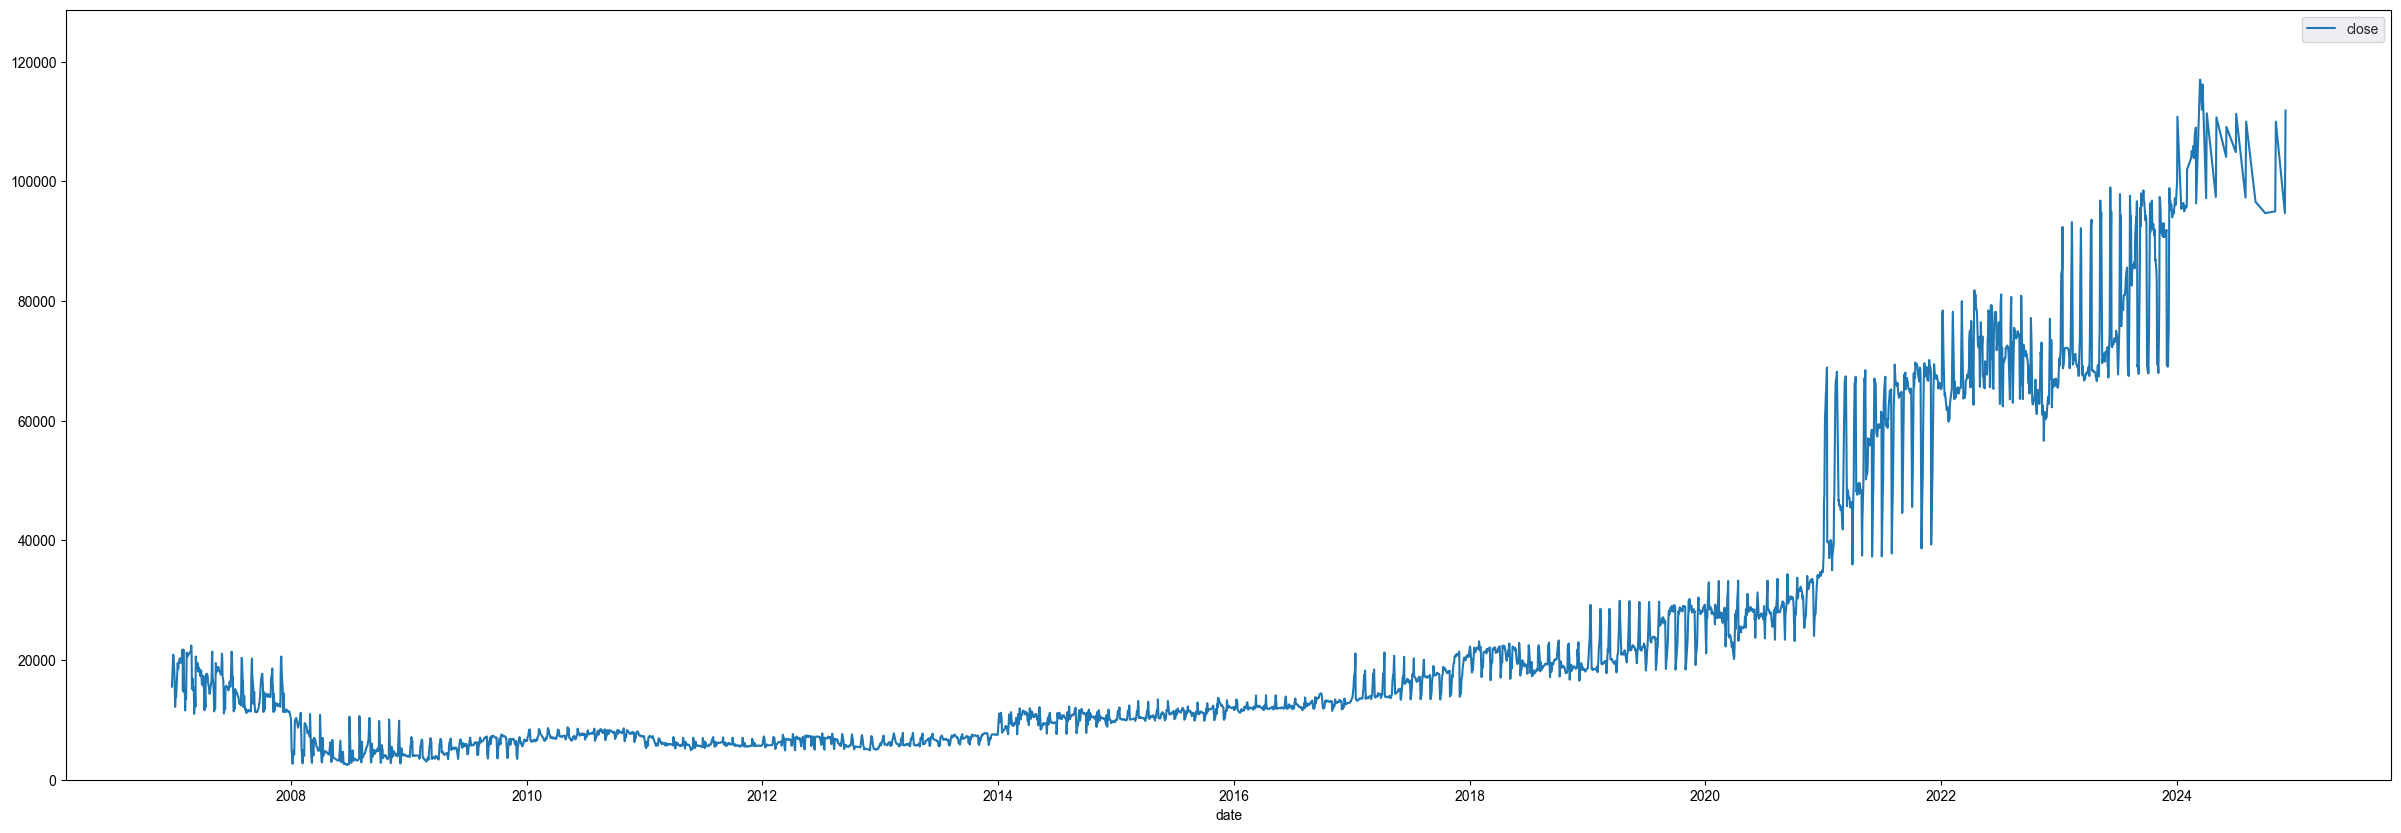

In [8]:
plt.figure(figsize=(30,10))
plt.ylim(0, df['close'].max() * 1.1)
#seaborn.lineplot(data= pd.DataFrame(df, columns=('date', 'close'))['2020'])
seaborn.set_style('darkgrid')
seaborn.lineplot(data= pd.DataFrame(df, columns=('date', 'close')))

In [9]:
df.drop('date', axis=1, inplace=True)
df

,open,highest,lowest,close,volume
date,,,,,
2024-03-21,115200.0,116200.0,114600.0,116200.0,3757800
2024-03-20,112300.0,115000.0,111100.0,114500.0,3475700
2024-03-19,113000.0,113000.0,111100.0,112000.0,3315400
2024-03-18,115800.0,115800.0,111100.0,113000.0,5884600
2024-03-15,116800.0,116800.0,114500.0,116000.0,3838400
...,...,...,...,...,...
2007-05-01,16693.0,16693.0,16693.0,16693.0,377800
2007-04-01,15917.0,15917.0,15917.0,15917.0,148510
2007-03-01,14838.0,15175.0,14838.0,15175.0,74660


In [10]:
df['tomorrow_close'] = df['close'].shift(1) # today close is last day's tomorrow close
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-21,115200.0,116200.0,114600.0,116200.0,3757800,NaN
2024-03-20,112300.0,115000.0,111100.0,114500.0,3475700,116200.0
2024-03-19,113000.0,113000.0,111100.0,112000.0,3315400,114500.0
2024-03-18,115800.0,115800.0,111100.0,113000.0,5884600,112000.0
2024-03-15,116800.0,116800.0,114500.0,116000.0,3838400,113000.0
...,...,...,...,...,...,...
2007-05-01,16693.0,16693.0,16693.0,16693.0,377800,16524.0
2007-04-01,15917.0,15917.0,15917.0,15917.0,148510,16693.0
2007-03-01,14838.0,15175.0,14838.0,15175.0,74660,15917.0


In [11]:
df.dropna(inplace=True) # drop the lastest row
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,112300.0,115000.0,111100.0,114500.0,3475700,116200.0
2024-03-19,113000.0,113000.0,111100.0,112000.0,3315400,114500.0
2024-03-18,115800.0,115800.0,111100.0,113000.0,5884600,112000.0
2024-03-15,116800.0,116800.0,114500.0,116000.0,3838400,113000.0
2024-03-14,118500.0,118500.0,115700.0,117000.0,3463000,116000.0
...,...,...,...,...,...,...
2007-05-01,16693.0,16693.0,16693.0,16693.0,377800,16524.0
2007-04-01,15917.0,15917.0,15917.0,15917.0,148510,16693.0
2007-03-01,14838.0,15175.0,14838.0,15175.0,74660,15917.0


Scaling data

1. scale each column -> the scores are great but the actual predict is suck
2. scale all columns at once -> same result like last method
3. scale only the 'volume' -> same thing happened
4. scale all but the 'volume' -> eh
5. scale 'volume' and the others with different scaler ->it seems that your model is performing very well on the task for which it was trained

In [12]:
scaler_volume = MinMaxScaler().fit(df['volume'].values.reshape(-1, 1))
scaler_prices = MinMaxScaler().fit(df[['open', 'close', 'highest', 'lowest', 'tomorrow_close']].values.reshape(-1, 1))
scaler_prices, scaler_volume

(MinMaxScaler(), MinMaxScaler())

In [13]:
df.columns

Index(['open', 'highest', 'lowest', 'close', 'volume', 'tomorrow_close'], dtype='object')

In [14]:
for col in df.columns:
    if col == 'volume':
        df[col] = pd.DataFrame(scaler_volume.transform(df[col].values.reshape(-1, 1)), index=df.index)
    elif col in ['open', 'highest', 'lowest', 'close', 'tomorrow_close']:
        df[col] = pd.DataFrame(scaler_prices.transform(df[col].values.reshape(-1, 1)), index=df.index)
        
df

,open,highest,lowest,close,volume,tomorrow_close
date,,,,,,
2024-03-20,0.946592,0.969850,0.936255,0.965543,0.138438,0.980187
2024-03-19,0.952622,0.952622,0.936255,0.944008,0.132050,0.965543
2024-03-18,0.976742,0.976742,0.936255,0.952622,0.234436,0.944008
2024-03-15,0.985356,0.985356,0.965543,0.978465,0.152892,0.952622
2024-03-14,1.000000,1.000000,0.975880,0.987079,0.137932,0.978465
...,...,...,...,...,...,...
2007-05-01,0.123019,0.123019,0.123019,0.123019,0.014983,0.121563
2007-04-01,0.116334,0.116334,0.116334,0.116334,0.005846,0.123019
2007-03-01,0.107039,0.109942,0.107039,0.109942,0.002903,0.116334


In [15]:
df.to_numpy()[0]

array([0.94659224, 0.96985046, 0.93625525, 0.96554338, 0.13843814,
       0.98018744])

In [74]:
dfValues = df.values
# create sequences of data X and target Y for training
X = []
Y = []
# number of days to look back is 30 days
look_back = 30
for i in range(len(dfValues) - look_back):
    X.append(dfValues[i : i + look_back, [0, 1, 2, 3, 4]]) # sequence of 30 days
    Y.append(dfValues[i + look_back, [5]]) # close price of next day

X = np.array(X) # contain 'open','highest', 'lowest', 'close', 'volume' of 30 days (respectively) or the predictors
Y = np.array(Y) # contain 'close_tomorrow', which is the exact close price of the next day, which is the target that we want to predict

In [77]:
# lstm need differnct set of X, which is 3 dimensions
lstm_X = X
lstm_Y = Y

In [78]:
# turn X from 3 dimesions to 2 dimensions, for other machine learning models
tmp_X = [] # tmp_X is used for swap calue with X, keep up
for i in range(len(X)):
    tmp_X.append(X[i].reshape(-1))

X, tmp_X = tmp_X, X
X[0].size # == 150, because it 30 days multiple by 5 features (which features?)

150

In [80]:
len(lstm_X), len(lstm_Y)

(4289, 4289)

In [79]:
len(Y), len(X) # make sure that len(X) == len(Y)

(4289, 4289)

In [66]:
# create train-test sets
splitPoint = int(0.7 * len(X)) # lenX == lenY, train set == 70%
X_train = X[:splitPoint]
X_test  = X[splitPoint:]
Y_train = Y[:splitPoint]
Y_test  = Y[splitPoint:]

LSTM (Long Short-term Memories)-----------------------------------------------------------------------------------------------------------------------------------------------------

In [81]:
# prepare train-test set for lstm model
# splitPoint is existed, make sure train set is about 70% of the whole dataset
lstm_X_train = lstm_X[:splitPoint]
lstm_X_test  = lstm_X[splitPoint:]
lstm_Y_train = lstm_Y[:splitPoint]
lstm_Y_test  = lstm_Y[splitPoint:]

In [69]:
# import models
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
#from keras.layers import RNN

In [70]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(30, 5)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

In [82]:
save_model = 'savedModel_LSTM.h5'
best_choice = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(lstm_X_train, lstm_Y_train, epochs=10, batch_size=32, callbacks=[best_choice])

Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 1: loss improved from inf to 0.00715, saving model to LSTM_savedModel.h5
94/94 [==============================] - 3s 10ms/step - loss: 0.0072
Epoch 2/10
89/94 [===========================>..] - ETA: 0s - loss: 1.1070e-04
Epoch 2: loss improved from 0.00715 to 0.00011, saving model to LSTM_savedModel.h5
94/94 [==============================] - 1s 8ms/step - loss: 1.0869e-04
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 1.1097e-04
Epoch 3: loss did not improve from 0.00011
94/94 [==============================] - 1s 8ms/step - loss: 1.1050e-04
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 1.0363e-04
Epoch 4: loss improved from 0.00011 to 0.00010, saving model to LSTM_savedModel.h5
94/94 [==============================] - 1s 8ms/step - loss: 1.0332e-04
Epoch 5/10
94/94 [==============================] - ETA: 0s - loss: 9.6855e-05
Epoch 5: loss improved from 0.00010 

In [83]:
loss = model.evaluate(lstm_X_test, lstm_Y_test)
lstm_Y_pred = model.predict(lstm_X_test)
r2 = r2_score(lstm_Y_test, lstm_Y_pred)
mae = mean_absolute_error(lstm_Y_test, lstm_Y_pred)
#loss # mse

41/41 [==============================] - 0s 3ms/step


In [84]:
print('LSTM:\nr2 :', r2, '\nmean absolute error : ', mae, '\nmean squared error : ', loss)

LSTM:
r2 : 0.9896484031852386 
mean absolute error :  0.0027297011319155685 
mean squared error :  1.3337588825379498e-05


Random Forest ------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
import joblib # for saving models weights
from sklearn.ensemble import RandomForestRegressor

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [87]:
rf_model.fit(X,Y) # turn this to rf_X_train/test and ...
rf_model

c:\Users\tranh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [88]:
joblib.dump(rf_model, 'savedModel_RandomForest.h5')

['savedModel_RandomForest.h5']

In [89]:
rf_Y_pred = rf_model.predict(X_test)
rf_Y_pred

array([0.0355358 , 0.03553184, 0.03553063, ..., 0.11677417, 0.10973219,
       0.10729903])

In [90]:
print(
    'Random Forest:\n',
    'r2 : ', r2_score(rf_Y_pred, rf_Y_test), '\n',
    'mae : ', mean_absolute_error(rf_Y_pred, rf_Y_test), '\n',
    'mse : ', mean_squared_error(rf_Y_pred, rf_Y_test), '\n',
    'rmse : ', root_mean_squared_error(rf_Y_pred, rf_Y_test)
)

Random Forest:
 r2 :  0.9999979521423337 
 mae :  2.370585945115688e-05 
 mse :  2.638723487912626e-09 
 rmse :  5.1368506771295446e-05


XGBoots -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
from xgboost import XGBRegressor

In [51]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Specify the objective function for regression task (minimize squared error)
    n_estimators=100,               # Number of boosting rounds (trees) to build
    max_depth=5,                    # Maximum depth of each tree
    learning_rate=0.1,              # Learning rate (shrinkage) of each tree's contribution
    gamma=0,                        # Minimum loss reduction required to make a further partition on a leaf node
    subsample=0.8,                  # Subsample ratio of the training instances (prevent overfitting)
    colsample_bytree=0.8,           # Subsample ratio of columns when constructing each tree
    random_state=42                 # Random seed for reproducibility
)

In [85]:
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [86]:
xgb_Y_pred = xgb_model.predict(X_test)
print(
    'XGBOOST:\n',
    'r2 : ', r2_score(xgb_Y_pred, Y_test), '\n',
    'mae : ', mean_absolute_error(xgb_Y_pred, Y_test), '\n',
    'mse : ', mean_squared_error(xgb_Y_pred, Y_test), '\n',
    'rmse : ', root_mean_squared_error(xgb_Y_pred, Y_test)
)

XGBOOST:
 r2 :  0.9747356623152699 
 mae :  0.0027316236598556726 
 mse :  2.8596050815169217e-05 
 rmse :  0.005347527542254384


ARIMA (Auto Regressive Integrated Moving Average) ImportError: numpy.core.multiarray failed to import

In [91]:
from statsmodels.tsa.arima.model import ARIMA

In [93]:
# Define ARIMA model parameters (p, d, q)
# p = 1  # Autoregressive order (AR)
# d = 1  # Differencing order (I)
# q = 1  # Moving average order (MA)
arm_model = ARIMA(Y_train, order=[1, 1, 1])
arm_model = arm_model.fit()

In [95]:
arm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3002
Model:                 ARIMA(1, 1, 1)   Log Likelihood               11221.154
Date:                Wed, 17 Apr 2024   AIC                         -22436.308
Time:                        05:04:55   BIC                         -22418.288
Sample:                             0   HQIC                        -22429.826
                               - 3002                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1740      0.283     -0.614      0.539      -0.729       0.381
ma.L1          0.2023      0.281      0.719      0.472      -0.349       0.754
sigma2      3.306e-05   2.85e-07    115.835      0.000    3.25e-05    3.36e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31753.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.02   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""